In [133]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
import operator
import numpy as np
import os
from PIL import Image
import glob
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import cv2
import math 

In [47]:
#main emotions are dataset comes with
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

#load data into our notebook
def load_emotions_data(path):
    x = []
    y = []
    for i, emotion in enumerate(emotions):
        print(f"\r  {path}/{emotion}... ({i+1}/{len(emotions)})          ", end='')
        for filename in glob.glob(f"{path}/{emotion}/*.jpg"):
            img = Image.open(filename)
            img = np.array(img.getdata()).reshape(48, 48) / 255
            x.append(img)
            y_onehot = np.zeros(len(emotions))
            y_onehot[i] = 1
            y.append(y_onehot)
    print(f"\r  loaded {path}.                      ")
    return np.array(x), np.array(y)

print("Loading image data...")
x_train, y_train = load_emotions_data("data/train")
x_test, y_test = load_emotions_data("data/test")


Loading image data...
  loaded data/train.                      
  loaded data/test.                      


In [48]:
#OUR MODEL
batch_size = 128
input_shape = (48, 48, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dense(len(emotions), activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [159]:
#train model
model.fit(x_train, y_train, batch_size=batch_size, epochs=1)

225/225 [==============================] - 30s 134ms/step - loss: 0.7807 - accuracy: 0.7158


57/57 [==============================] - 2s 37ms/step - loss: 1.4412 - accuracy: 0.5173


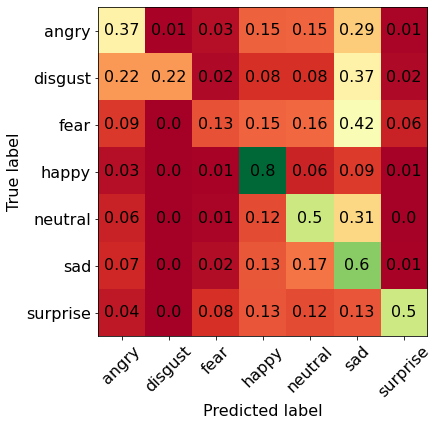

In [160]:
#display confusion matrix to demonstrate accuracy
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.RdYlGn)
    # fig.colorbar(matrix) 
    for i in range(0,len(emotions)):
        for j in range(0,len(emotions)):  
            ax.text(j,i,np.round(cm[i,j],2),va='center', ha='center')
    ticks = np.arange(len(emotions))
    ax.set_xticks(ticks)
    ax.set_xticklabels(emotions, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(emotions)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

_ = model.evaluate(x_test, y_test, batch_size=batch_size)

y_prob = model.predict(x_test, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y_test]

plot_confusion_matrix(y_true, y_pred)
plt.show()

In [78]:
#dictonary which saves the basic emojis and allows for easy mapping
emojiDict = {'happy': "\U0001F603",
             'surprise':"\U0001F62E",
             'angry':"\U0001F621",
             'neutral': "\U0001F610",
             'disgust':"\U0001F922",
             'fear':"\U0001F631",
             "sad":"\U0001F625"}
emojiDict

{'happy': '😃',
 'surprise': '😮',
 'angry': '😡',
 'neutral': '😐',
 'disgust': '🤢',
 'fear': '😱',
 'sad': '😥'}

In [111]:
#use open cv to get real time camera/image data

cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    
    #get cropped image so it focuses on face
    faces = face_cascade.detectMultiScale(frame, 1.1, 8)
    if(len(faces) > 0):
        (x, y, w, h) = faces[0]
    else:
        x, y, w, h = 0, 0, 50, 1
    if(w > h):
        w = h
    else:
        h = w
    cropped_image = frame[y:y+h, x:x+w]
    
    #makes sure image is in correct format for model... reformatting
    img = Image.fromarray(cropped_image , 'L')
    img = img.resize((48, 48))
    img = np.array(img.getdata())
    img = img.reshape(1, 48, 48, 1)
    img = img/255
    
    #run model and get probabilities for emoji
    y_probs = model(img).numpy().flatten()
    y_preds = np.flip(np.argsort(y_probs)).flatten()
    y_preds = [(emojiDict[emotions[y_preds[i]]], np.round(y_probs.item(y_preds[i]), 2)) for i in range(len(emotions))]

    print(f"\r{y_preds}".ljust(150), end="")
    #print(y_probs)

    cv2.imshow("preview", cropped_image)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break


vc.release()
cv2.destroyWindow("preview")
cv2.waitKey(1)


[('😃', 0.74), ('😥', 0.2), ('🤢', 0.02), ('😐', 0.02), ('😡', 0.01), ('😱', 0.01), ('😮', 0.0)]                                                            

KeyboardInterrupt: 

In [157]:
#makes a dictionary for each emoji and their given values for each of the 7 emotions
#does this by using model to analyze pre matched photos to their given emoji
import os
facePredict = {}
directory = 'faces'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    img = Image.open(f)

    img = np.array(img.getdata()).reshape(48, 48) / 255
    img = np.expand_dims(img,0)
    y_probs = model(img).numpy().flatten()
    y_predss = np.flip(np.argsort(y_probs)).flatten()
    y_predss = [(emojiDict[emotions[y_predss[i]]], np.round(y_probs.item(y_predss[i]), 2)) for i in range(len(emotions))]

    
    if os.path.isfile(f):
        facePredict[f[7:-4]] =y_predss
        #print((f[7:-4]))
facePredict

{'': [('😐', 0.77),
  ('😡', 0.12),
  ('😥', 0.07),
  ('😱', 0.04),
  ('😃', 0.01),
  ('🤢', 0.0),
  ('😮', 0.0)]}

In [158]:
#calculates how close the expression is to an emoji
def dist(one, two):
    l = ['😥','😱','😐','😡','😃','🤢','😮']
    value = 0
    for i in range(7):
        val = 0
        if(one[i][0] == l[i]):
            val+=one[i][1]
        if(two[i][0] == l[i]):
            val-=two[i][1]
        print(value)
        val = val*val
        value+=val
    return math.sqrt(value)           
print(y_preds)
print(facePredict['🤔'])
dist(y_preds,facePredict['🤔'])


[('😥', 0.64), ('😡', 0.21), ('😱', 0.06), ('😐', 0.04), ('🤢', 0.03), ('😃', 0.02), ('😮', 0.0)]


KeyError: '🤔'

In [156]:
#goes through each emoji and sees how close it is... 
#returns the 3 most likely emoji to match expression
dictt = {}
for item in facePredict.items():
    distt = dist(y_preds, item[1])
    dictt[item[0]]= distt
  
sorted_dicdata = sorted(dictt.items(), key=operator.itemgetter(1),    reverse=True)
    

sorted_dicdata[:3]

0
0.4096
0.4096
0.4096
0.4096
0.4097
0.4097


[('', 0.6400781202322104)]

In [143]:
#FINAL.... RETURNS 3 EMOJIS REAL TIME

cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    
    #get cropped image so it focuses on face
    faces = face_cascade.detectMultiScale(frame, 1.1, 8)
    if(len(faces) > 0):
        (x, y, w, h) = faces[0]
    else:
        x, y, w, h = 0, 0, 50, 1
    if(w > h):
        w = h
    else:
        h = w
    cropped_image = frame[y:y+h, x:x+w]
    
    #makes sure image is in correct format for model... reformatting
    img = Image.fromarray(cropped_image , 'L')
    img = img.resize((48, 48))
    img = np.array(img.getdata())
    img = img.reshape(1, 48, 48, 1)
    img = img/255
    
    #run model and get probabilities for emoji
    y_probs = model(img).numpy().flatten()
    y_preds = np.flip(np.argsort(y_probs)).flatten()
    y_preds = [(emojiDict[emotions[y_preds[i]]], np.round(y_probs.item(y_preds[i]), 2)) for i in range(len(emotions))]

    #print(f"\r{y_preds}".ljust(150), end="")
    dictt = {}
    for item in facePredict.items():
        distt = dist(y_preds, item[1])
        dictt[item[0]]= distt
  
    sorted_dicdata = sorted(dictt.items(), key=operator.itemgetter(1),    reverse=True)
    print(sorted_dicdata[:3])
    

    #print(y_probs)

    cv2.imshow("preview", cropped_image)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break


vc.release()
cv2.destroyWindow("preview")
cv2.waitKey(1)


[('🤔', 0.8468175718535841), ('🥴', 0.7760154637634485), ('😳', 0.7664854858377945)]
[('🤔', 0.8631917515824626), ('🥴', 0.7930952023559341), ('😳', 0.7845380806563821)]
[('🤔', 0.8468175718535841), ('🥴', 0.7760154637634485), ('😳', 0.7664854858377945)]
[('🤔', 0.8189017035029296), ('🥴', 0.7446475676452586), ('😳', 0.7355270219373317)]
[('🤔', 0.8729833904490968), ('🥴', 0.8043631020876082), ('😳', 0.7952986860293434)]
[('🤔', 0.8645808232895291), ('🥴', 0.795361553005927), ('😳', 0.7860661549767932)]
[('🤔', 0.8468175718535841), ('🥴', 0.7760154637634485), ('😳', 0.7664854858377945)]
[('🤔', 0.874128137060008), ('🥴', 0.8058535847162313), ('😳', 0.7965550828411052)]
[('🤔', 0.8386894538504702), ('🥴', 0.7672678802087313), ('😳', 0.757495874576225)]
[('🤔', 0.8475258108164022), ('🥴', 0.7769169839822013), ('😳', 0.7672678802087313)]
[('🤔', 0.8394641147779933), ('🥴', 0.7682447526667526), ('😳', 0.7583534795858723)]
[('🤔', 0.8458723307923011), ('🥴', 0.7742092740338363), ('😳', 0.7654410493303844)]
[('🤔', 0.8634234187

[('🤔', 0.8542833253669417), ('🥴', 0.7833900688673555), ('😳', 0.7747257579298625)]
[('🤔', 0.8277076778670112), ('🥴', 0.7543208866258444), ('😳', 0.7453187237685632)]
[('🤔', 0.8721238444166058), ('🥴', 0.8028075734570521), ('😳', 0.79435508432942)]
[('🤔', 0.8189017035029296), ('🥴', 0.7446475676452586), ('😳', 0.7355270219373317)]
[('🤔', 0.7753063910480811), ('🥴', 0.696419413859206), ('😳', 0.6866585760041158)]
[('🤔', 0.7666811592833099), ('🥴', 0.686804193347711), ('😳', 0.6769047200308179)]
[('🤔', 0.7926537705707327), ('🥴', 0.7156814934033154), ('😳', 0.7061869440877535)]
[('🤔', 0.8013738203859668), ('🥴', 0.7253275122315435), ('😳', 0.7159608927867499)]
[('🤔', 0.8542833253669417), ('🥴', 0.7833900688673555), ('😳', 0.7747257579298625)]
[('🤔', 0.8365404951345751), ('🥴', 0.7640026177965623), ('😳', 0.7551158851461145)]
[('🤔', 0.8365404951345751), ('🥴', 0.7640026177965623), ('😳', 0.7551158851461145)]
[('🤔', 0.8631917515824626), ('🥴', 0.7930952023559341), ('😳', 0.7845380806563821)]
[('🤔', 0.75808970445

[('🤔', 0.810617048920142), ('🥴', 0.7355270219373317), ('😳', 0.7262919523166974)]
[('🤔', 0.8545759182190895), ('🥴', 0.7837091297158659), ('😳', 0.7750483855863451)]
[('🤔', 0.8458723307923011), ('🥴', 0.7742092740338363), ('😳', 0.7654410493303844)]
[('🤔', 0.8203048213926333), ('🥴', 0.7468600939935135), ('😳', 0.7370888684548152)]
[('🤔', 0.837018518313663), ('🥴', 0.7645259969418959), ('😳', 0.7556454194925023)]
[('🤔', 0.7580897044545586), ('🥴', 0.6772001181334806), ('😳', 0.6671581521648372)]
[('🤔', 0.7410128204019145), ('🥴', 0.6580273550544841), ('😳', 0.6476881965884511)]
[('🤔', 0.7666811592833099), ('🥴', 0.686804193347711), ('😳', 0.6769047200308179)]
[('🤔', 0.7839642849007855), ('🥴', 0.7060453243241542), ('😳', 0.696419413859206)]
[('🤔', 0.7926537705707327), ('🥴', 0.7156814934033154), ('😳', 0.7061869440877535)]
[('🤔', 0.793158243984137), ('🥴', 0.7162401831787991), ('😳', 0.7067531393633848)]
[('🤔', 0.7753063910480811), ('🥴', 0.696419413859206), ('😳', 0.6866585760041158)]
[('🤔', 0.7156814934033

KeyboardInterrupt: 